# Numerical Simulation of Panel Cooling

## Channel Model (with radiation)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class channel:
  def __init__(self, T_fluid_i = 290, T_ambient = 330, panel_dimensions = (1, .02, .01), channel_height = .02, mass_flow_rate = .001,
               fluid_specific_heat = 4186, fluid_density = 1000, h_fluid = 70, h_amb = 10, k = .3, intensity = 1000, x_steps = 100, flow_forward = True):
    self.sigma = 5.67e-8  # Stefan-Boltzmann constant (W/m^2·K^4)
    self.c = 700  # Specific heat capacity (J/kg·K)
    self.k = k
    self.alpha = 0.85  # Absorptivity
    self.epsilon = 0.85  # Emissivity
    self.G = intensity  # Solar irradiance (W/m^2)
    self.h = h_amb  # Convective heat transfer coefficient (W/m^2·K)
    self.mass_flow_rate = mass_flow_rate  # Mass flow rate (kg/s)
    self.T_ambient = T_ambient  # Ambient temperature (K)
    self.T_fluid_i = T_fluid_i
    self.flow_forward = flow_forward

    # Dimensions
    self.panel_length, self.panel_width, self.panel_thickness = panel_dimensions
    self.x_length = self.panel_length / x_steps
    self.x_steps = x_steps
    y_length = self.panel_width
    self.A = self.x_length * y_length  # Surface area of the block (m^2)
    self.block_volume = self.A * channel_height
    self.A_across = self.x_length * self.panel_thickness
    self.fluid_mass = fluid_density * self.block_volume  # Mass of the cooling fluid (kg)
    self.panel_length_array = np.linspace(0, self.panel_length, x_steps)
    self.T_fluid_matrix = np.ones(x_steps) * T_fluid_i  #time, long, short dir
    self.T_panel_matrix = np.ones(x_steps) * T_fluid_i


    # Fluid properties
    self.h_fluid = h_fluid  # Heat transfer coefficient with cooling fluid (W/m^2·K)
    self.fluid_specific_heat = fluid_specific_heat  # Specific heat capacity of water (J/kg·K)
    self.fluid_speed = mass_flow_rate / (fluid_density * y_length * channel_height)  # Fluid speed (m/s)

    # Panel Properties
    self.panel_density = 2300 # kg/m^3
    self.m = self.panel_density * self.panel_thickness * self.A  # Mass of the material (kg)

    # Time parameters
    self.num_timesteps = 20
    self.time_duration = self.fluid_mass / mass_flow_rate  # Total time (seconds)
    self.time_step = self.time_duration / self.num_timesteps  # Time step (seconds)


  def heat_transfer_rate(self, T, T_fluid_current):  # in K/s
      """Calculate the net heat transfer rate (dT/dt) for the material."""
      absorbed = self.alpha * self.G * self.A
      radiative_loss = 0 # self.epsilon * self.sigma * self.A * (self.T_ambient**4 - T**4)
      convective_gain = self.h * self.A * (self.T_ambient - T)
      fluid_cooling_loss = self.h_fluid * self.A * (T - T_fluid_current)
      net_heat_transfer = absorbed + convective_gain - fluid_cooling_loss  # - radiative_loss
      return net_heat_transfer / (self.m * self.c)

  def fluid_heat_transfer_rate(self, T, T_fluid_current):  # in K/s
      """Calculate the temperature change in the cooling fluid."""
      heat_transfer_to_fluid = self.h_fluid * self.A * (T - T_fluid_current)
      return heat_transfer_to_fluid / (self.fluid_mass * self.fluid_specific_heat)

  def cool(self, T_initial, T_fluid):
    '''return temps of panel and fluid of one block after self.num_timesteps of heat transfer from the environment and fluid'''
    # Initial conditions
    T = T_initial  # Current temperature (K)
    T_fluid_current = T_fluid  # Current fluid temperature (K)

    # Arrays to store results
    temperatures = [T_initial]
    fluid_temperatures = [T_fluid_current]

    # Numerical solution using Euler's method
    for _ in range(self.num_timesteps):
        dTdt = self.heat_transfer_rate(T, T_fluid_current)
        dT_fluid_dt = self.fluid_heat_transfer_rate(T, T_fluid_current)
        T += dTdt * self.time_step
        T_fluid_current += dT_fluid_dt * self.time_step
    return [T, T_fluid_current]

  def flow(self, flow_T = None):
    if self.flow_forward:
      self.T_fluid_matrix[1:] = self.T_fluid_matrix[:-1]
      self.T_fluid_matrix[0] = self.T_fluid_i
      if flow_T is not None:
        self.T_fluid_matrix[0] = flow_T
    else:
      self.T_fluid_matrix[:-1] = self.T_fluid_matrix[1:]
      self.T_fluid_matrix[-1] = self.T_fluid_i
      if flow_T is not None:
        self.T_fluid_matrix[-1] = flow_T

  def cool_and_flow(self, flow_T = None):
    for i in range(len(self.T_fluid_matrix)):
      self.T_panel_matrix[i], self.T_fluid_matrix[i] = self.cool(self.T_panel_matrix[i], self.T_fluid_matrix[i])
    self.flow(flow_T)

  def cool_and_flow_iter(self, iter):
    for i in range(iter):
      self.cool_and_flow()

  def diffuse(self):
    # Discretization
    alpha = 1.5e-6 * self.time_step / self.x_length**2
    #alpha = D * self.time_step / self.x_length**2 # Stability parameter (alpha = D * dt / dx^2)

    # Create an array to store concentration at each time step
    T_time = np.zeros((self.num_timesteps, self.x_steps))
    T = self.T_fluid_matrix.copy()
    T_time[0, :] = T  # Set initial condition

    # Time stepping loop (FTCS scheme)
    for n in range(1, self.num_timesteps):
        T_new = T.copy()  # Create a new array for the next time step
        for i in range(1, self.x_steps - 1):
            T_new[i] = T[i] + alpha * (T[i+1] - 2*T[i] + T[i-1])  # FTCS update rule
        T = T_new
        T_time[n, :] = T  # Store the updated concentration
    self.T_fluid_matrix = T_time[-1, :]

  def plot(self):
    plt.figure(figsize=(6, 4))
    plt.plot(self.panel_length_array, self.T_panel_matrix, label="Surface Temperature")
    plt.plot(self.panel_length_array, self.T_fluid_matrix, label="Cooling Fluid Temperature", linestyle="--")
    plt.axhline(self.T_ambient, color="r", linestyle="--", label="Ambient Temperature")
    plt.title("Transient Temperature of Solar Panel and Cooling Fluid")
    plt.xlabel("Panel x-Coordinate (m)")
    plt.ylabel("Temperature (K)")
    plt.legend()
    plt.grid()
    plt.show()


In [3]:
cha = channel(panel_dimensions = (1, .06, .01), channel_height = .02, mass_flow_rate = .002,
               fluid_specific_heat = 1000, intensity = 300, fluid_density = 1.22, h_fluid = 20, x_steps = 50)

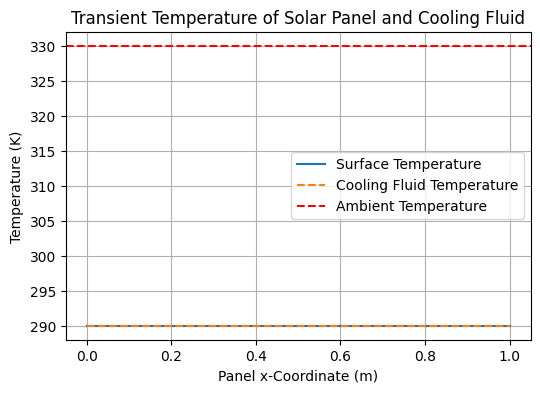

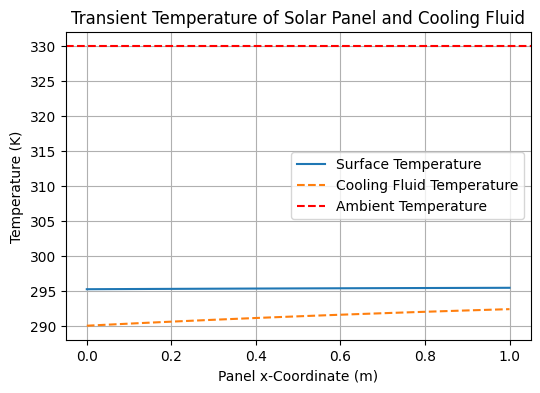

In [4]:
cha.plot()
cha.cool_and_flow_iter(10000)
cha.plot()

In [ ]:
cha.fluid_speed

3.4153005464480874

In [ ]:
def deltaT(m, c, A, h, dt, thi, tci):
  return float(h*A/m/c*(thi-tci)*dt)

def diffusion(T_panel1, T_panel2, A, m, k, c, dt, dx):
  T_panel1_new, T_panel2_new = T_panel1.copy(), T_panel2.copy()
  for i in range(len(T_panel1)):
    q = k*A*(T_panel1[i] - T_panel2[i]) * dt / dx
    T_panel1_new[i] -= q / m / c
    T_panel2_new[i] += q / m / c
  return T_panel1_new, T_panel2_new


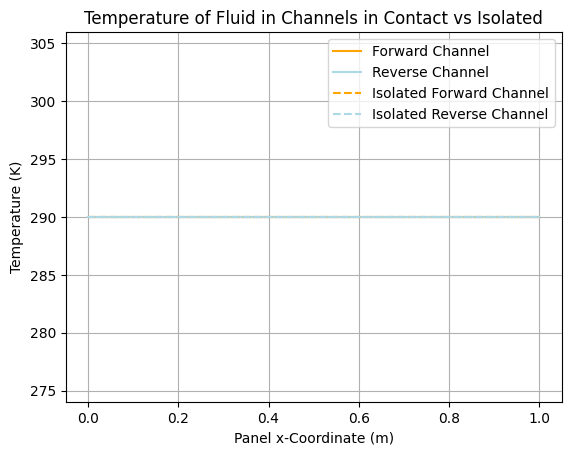

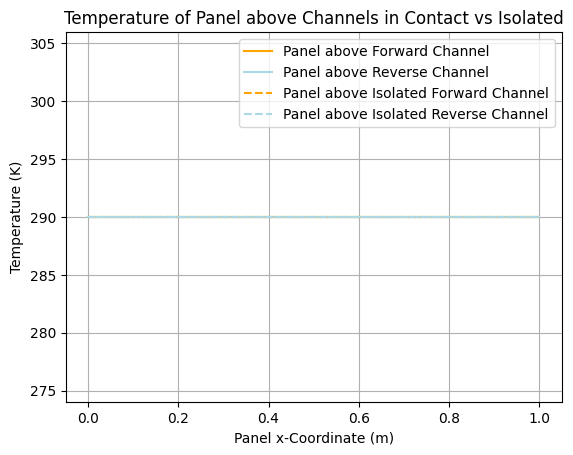

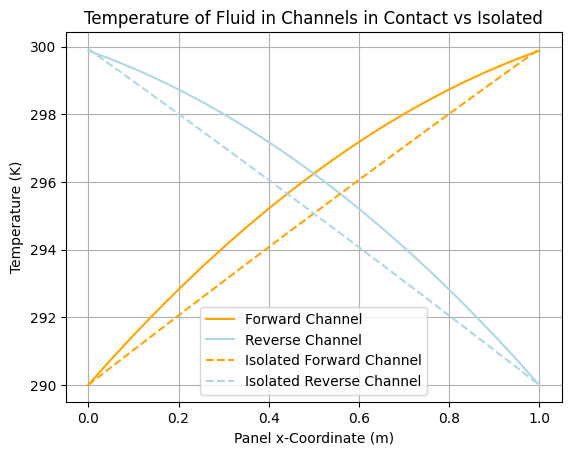

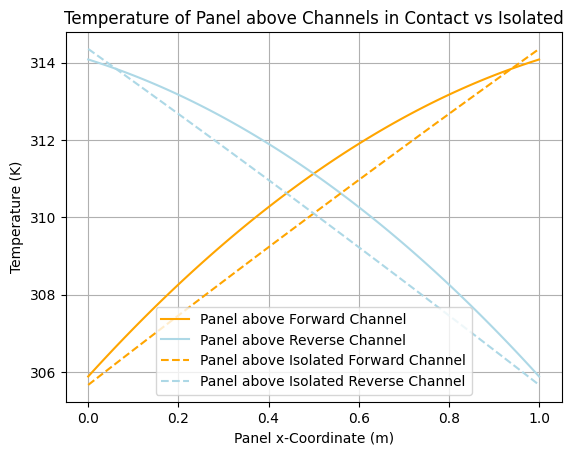

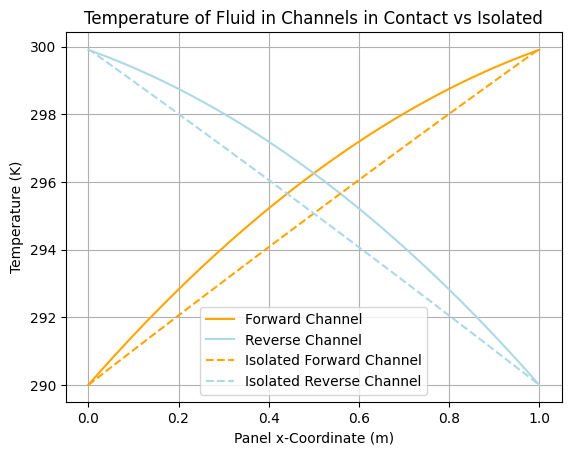

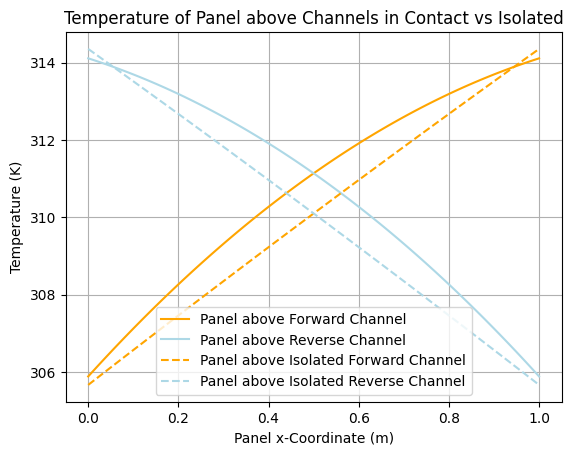

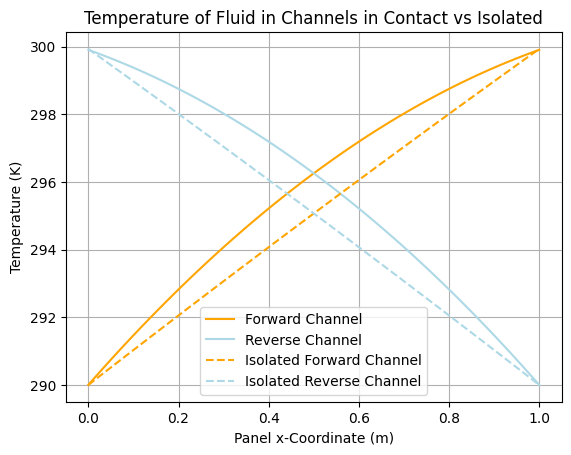

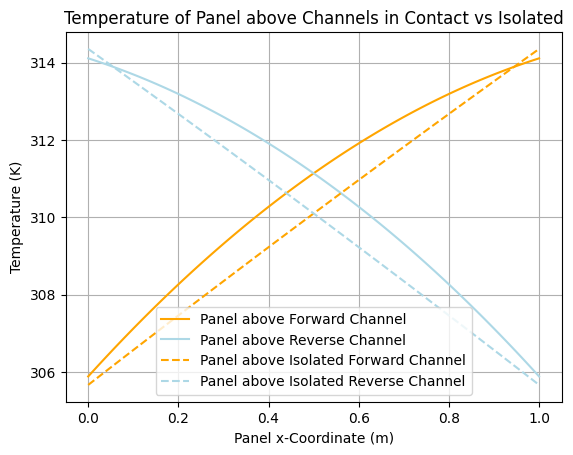

In [ ]:

#T_fluid_i = 280, panel_dimensions = (1, .03, .0025), mass_flow_rate = .0005
channel1 = channel(panel_dimensions = (1, .02, .0025), mass_flow_rate = .0005)
channel2 = channel(panel_dimensions = (1, .02, .0025), mass_flow_rate = .0005, flow_forward = False)
channel3 = channel(panel_dimensions = (1, .02, .0025), mass_flow_rate = .0005)
channel4 = channel(panel_dimensions = (1, .02, .0025), mass_flow_rate = .0005, flow_forward = False)
#channel5 = channel(mass_flow_rate = .002, panel_dimensions = (1, .04, .01))

for i in range(1000):
  T1 = channel1.T_fluid_matrix.copy()
  T2 = channel2.T_fluid_matrix.copy()
  if i % 250 == 0:
    x = channel1.panel_length_array
    plt.plot(x, channel1.T_fluid_matrix, label="Forward Channel", color="orange")
    plt.plot(x, channel2.T_fluid_matrix, label="Reverse Channel", color="lightblue")
    plt.plot(x, channel3.T_fluid_matrix, label="Isolated Forward Channel", color="orange", linestyle="--")
    plt.plot(x, channel4.T_fluid_matrix, label="Isolated Reverse Channel", color="lightblue", linestyle="--")
    #plt.plot(x, channel5.T_fluid_matrix, label="Thicker Channel", color="pink", linestyle="--")
    plt.title("Temperature of Fluid in Channels in Contact vs Isolated")
    plt.xlabel("Panel x-Coordinate (m)")
    plt.ylabel("Temperature (K)")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(x, channel1.T_panel_matrix, label="Panel above Forward Channel", color="orange")
    plt.plot(x, channel2.T_panel_matrix, label="Panel above Reverse Channel", color="lightblue")
    plt.plot(x, channel3.T_panel_matrix, label="Panel above Isolated Forward Channel", color="orange", linestyle="--")
    plt.plot(x, channel4.T_panel_matrix, label="Panel above Isolated Reverse Channel", color="lightblue", linestyle="--")
    #plt.plot(x, channel5.T_panel_matrix, label="Panel above Thicker Channel", color="pink", linestyle="--")
    plt.title("Temperature of Panel above Channels in Contact vs Isolated")
    plt.xlabel("Panel x-Coordinate (m)")
    plt.ylabel("Temperature (K)")
    plt.legend()
    plt.grid()
    plt.show()

  for j in range(len(T1)):
    dT = deltaT(channel1.fluid_mass, channel1.fluid_specific_heat, channel1.A, 50, channel1.time_duration, T1[j], T2[j])
    T1[j] -= dT
    T2[j] += dT

  channel1.T_fluid_matrix = T1
  channel2.T_fluid_matrix = T2
  channel1.T_panel_matrix, channel2.T_panel_matrix = diffusion(channel1.T_panel_matrix, channel2.T_panel_matrix, channel1.A_across,
                                                               channel1.m, channel1.k, channel1.c, channel1.time_duration, channel1.panel_width)
  channel1.cool_and_flow()
  channel2.cool_and_flow() #flow_T = T1[-1]
  channel3.cool_and_flow()
  channel4.cool_and_flow() #flow_T = channel3.T_fluid_matrix[-1])
  #channel5.cool_and_flow()
  channel1.diffuse()
  channel2.diffuse()
  channel3.diffuse()
  channel4.diffuse()
  #channel5.diffuse()

In [ ]:
sum(channel1.T_panel_matrix) + sum(channel2.T_panel_matrix) - sum(channel3.T_panel_matrix) - sum(channel4.T_panel_matrix)

28.79617702374162

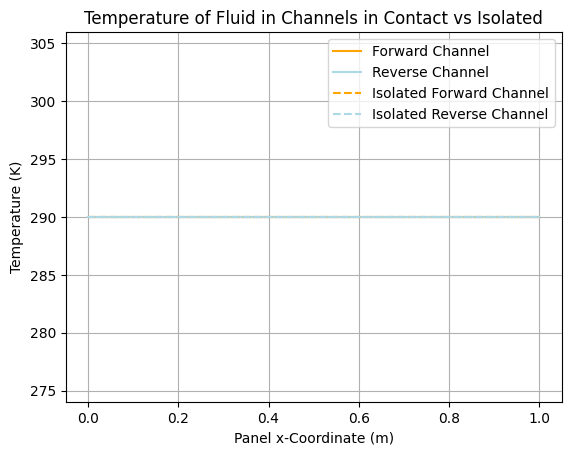

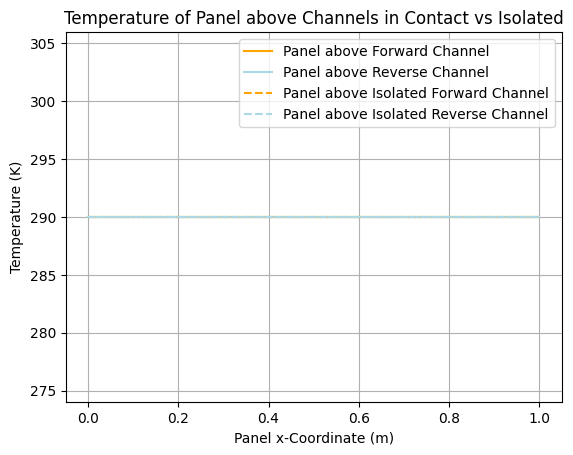

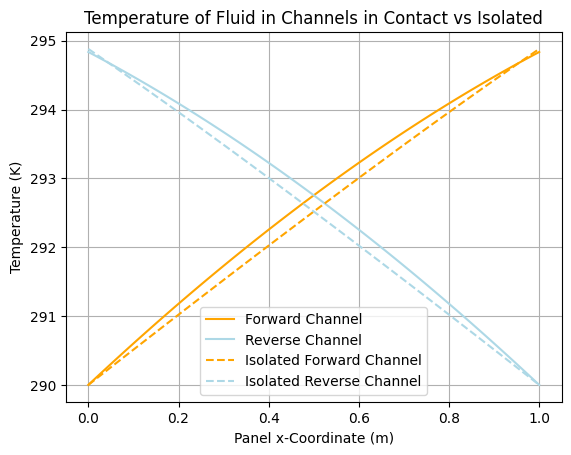

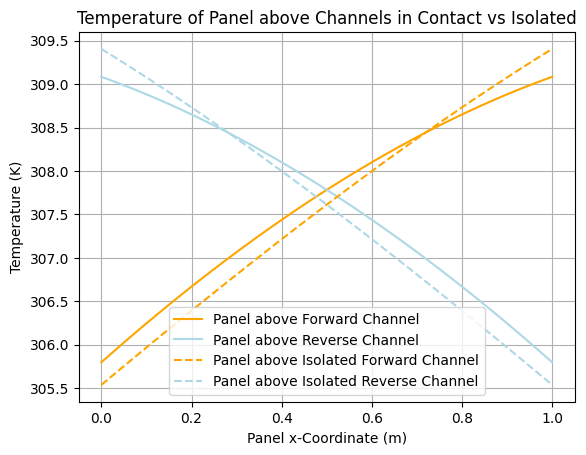

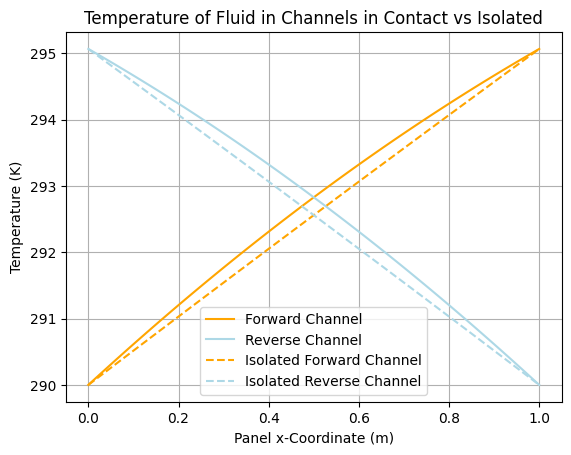

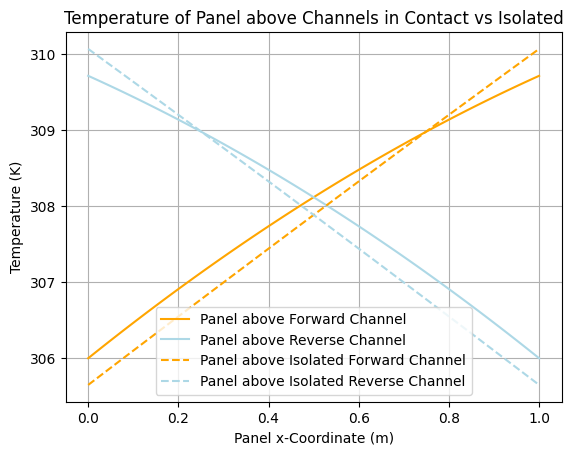

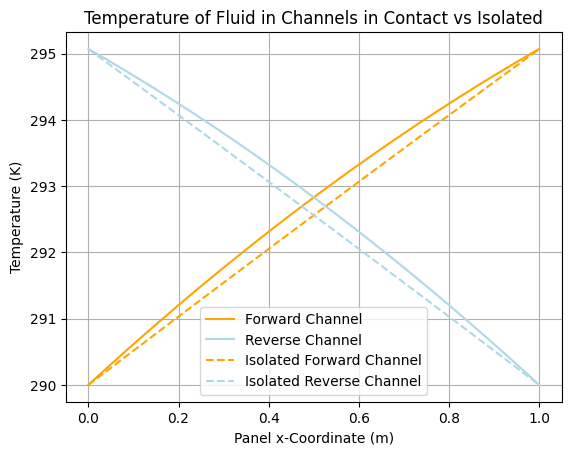

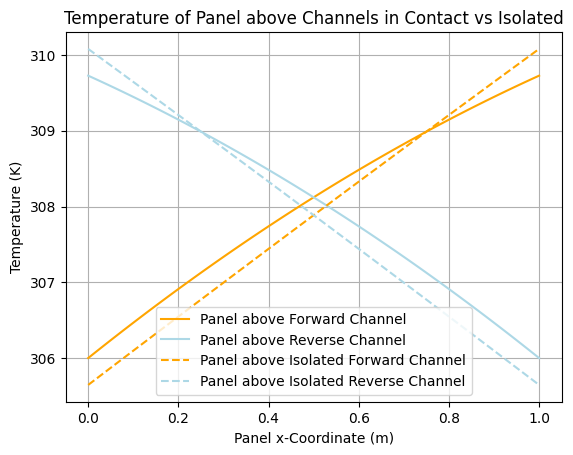

In [ ]:

#T_fluid_i = 280, panel_dimensions = (1, .03, .0025), mass_flow_rate = .0005
channel1 = channel(mass_flow_rate = .001)
channel2 = channel(mass_flow_rate = .001, flow_forward = False)
channel3 = channel(mass_flow_rate = .001)
channel4 = channel(mass_flow_rate = .001, flow_forward = False)
#channel5 = channel(mass_flow_rate = .002, panel_dimensions = (1, .04, .01))

for i in range(1000):
  T1 = channel1.T_fluid_matrix.copy()
  T2 = channel2.T_fluid_matrix.copy()
  if i % 250 == 0:
    x = channel1.panel_length_array
    plt.plot(x, channel1.T_fluid_matrix, label="Forward Channel", color="orange")
    plt.plot(x, channel2.T_fluid_matrix, label="Reverse Channel", color="lightblue")
    plt.plot(x, channel3.T_fluid_matrix, label="Isolated Forward Channel", color="orange", linestyle="--")
    plt.plot(x, channel4.T_fluid_matrix, label="Isolated Reverse Channel", color="lightblue", linestyle="--")
    #plt.plot(x, channel5.T_fluid_matrix, label="Thicker Channel", color="pink", linestyle="--")
    plt.title("Temperature of Fluid in Channels in Contact vs Isolated")
    plt.xlabel("Panel x-Coordinate (m)")
    plt.ylabel("Temperature (K)")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(x, channel1.T_panel_matrix, label="Panel above Forward Channel", color="orange")
    plt.plot(x, channel2.T_panel_matrix, label="Panel above Reverse Channel", color="lightblue")
    plt.plot(x, channel3.T_panel_matrix, label="Panel above Isolated Forward Channel", color="orange", linestyle="--")
    plt.plot(x, channel4.T_panel_matrix, label="Panel above Isolated Reverse Channel", color="lightblue", linestyle="--")
    #plt.plot(x, channel5.T_panel_matrix, label="Panel above Thicker Channel", color="pink", linestyle="--")
    plt.title("Temperature of Panel above Channels in Contact vs Isolated")
    plt.xlabel("Panel x-Coordinate (m)")
    plt.ylabel("Temperature (K)")
    plt.legend()
    plt.grid()
    plt.show()

  for j in range(len(T1)):
    dT = deltaT(channel1.fluid_mass, channel1.fluid_specific_heat, channel1.A, 40, channel1.time_duration, T1[j], T2[j])
    T1[j] -= dT
    T2[j] += dT

  channel1.T_fluid_matrix = T1
  channel2.T_fluid_matrix = T2
  channel1.T_panel_matrix, channel2.T_panel_matrix = diffusion(channel1.T_panel_matrix, channel2.T_panel_matrix, channel1.A_across,
                                                               channel1.m, channel1.k, channel1.c, channel1.time_duration, channel1.panel_width)
  channel1.cool_and_flow()
  channel2.cool_and_flow() #flow_T = T1[-1]
  channel3.cool_and_flow()
  channel4.cool_and_flow() #flow_T = channel3.T_fluid_matrix[-1])
  #channel5.cool_and_flow()
  channel1.diffuse()
  channel2.diffuse()
  channel3.diffuse()
  channel4.diffuse()
  #channel5.diffuse()

In [ ]:
sum(channel1.T_panel_matrix) + sum(channel2.T_panel_matrix) - sum(channel3.T_panel_matrix) - sum(channel4.T_panel_matrix)

31.201526861157618

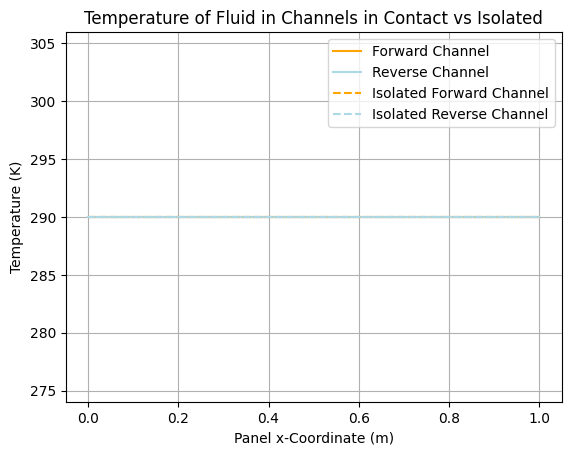

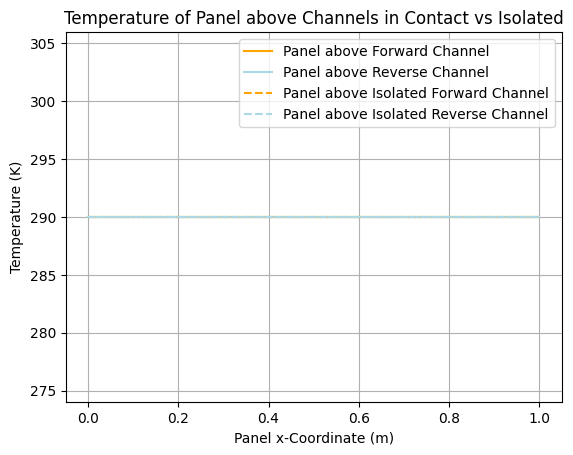

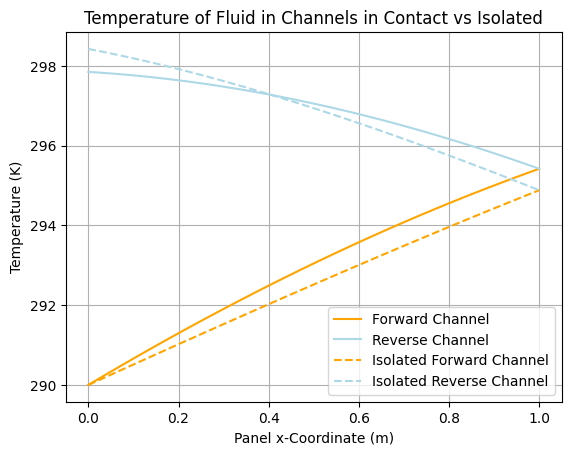

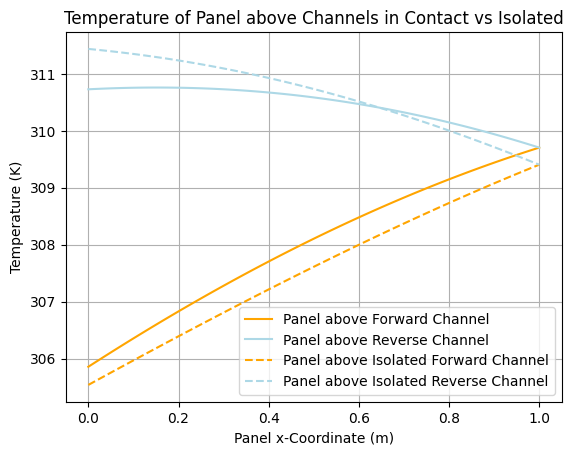

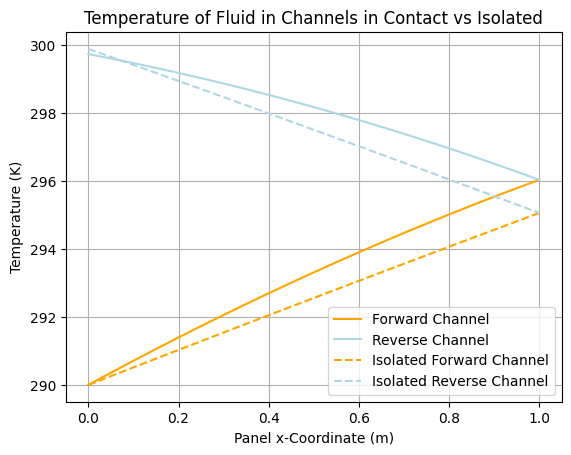

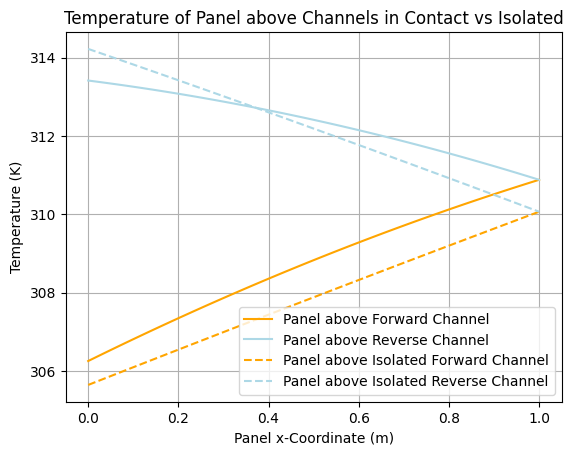

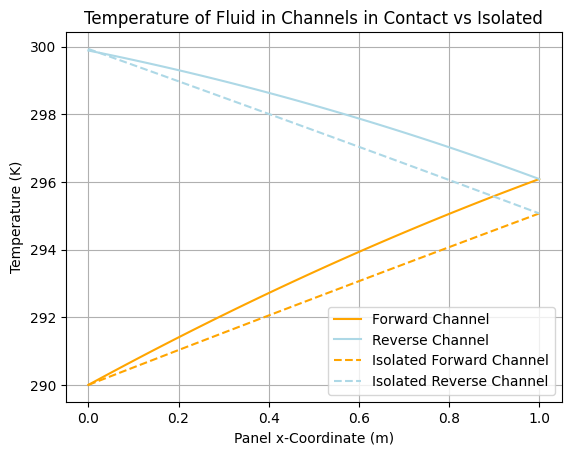

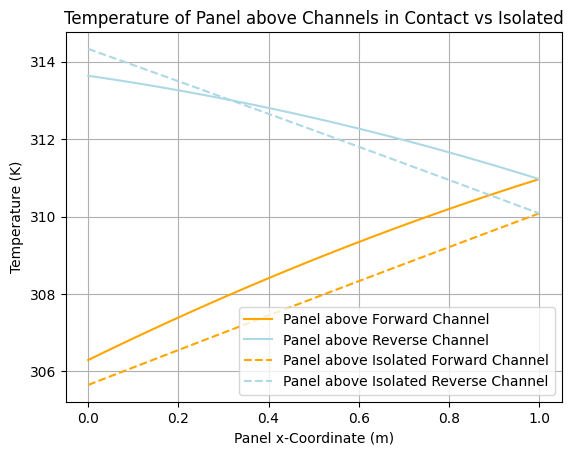

In [ ]:

#T_fluid_i = 280, panel_dimensions = (1, .03, .0025), mass_flow_rate = .0005
channel1 = channel(mass_flow_rate = .001)
channel2 = channel(mass_flow_rate = .001, flow_forward = False)
channel3 = channel(mass_flow_rate = .001)
channel4 = channel(mass_flow_rate = .001, flow_forward = False)
#channel5 = channel(mass_flow_rate = .002, panel_dimensions = (1, .04, .01))

for i in range(1000):
  T1 = channel1.T_fluid_matrix.copy()
  T2 = channel2.T_fluid_matrix.copy()
  if i % 250 == 0:
    x = channel1.panel_length_array
    plt.plot(x, channel1.T_fluid_matrix, label="Forward Channel", color="orange")
    plt.plot(x, channel2.T_fluid_matrix, label="Reverse Channel", color="lightblue")
    plt.plot(x, channel3.T_fluid_matrix, label="Isolated Forward Channel", color="orange", linestyle="--")
    plt.plot(x, channel4.T_fluid_matrix, label="Isolated Reverse Channel", color="lightblue", linestyle="--")
    #plt.plot(x, channel5.T_fluid_matrix, label="Thicker Channel", color="pink", linestyle="--")
    plt.title("Temperature of Fluid in Channels in Contact vs Isolated")
    plt.xlabel("Panel x-Coordinate (m)")
    plt.ylabel("Temperature (K)")
    plt.legend()
    plt.grid()
    plt.show()

    plt.plot(x, channel1.T_panel_matrix, label="Panel above Forward Channel", color="orange")
    plt.plot(x, channel2.T_panel_matrix, label="Panel above Reverse Channel", color="lightblue")
    plt.plot(x, channel3.T_panel_matrix, label="Panel above Isolated Forward Channel", color="orange", linestyle="--")
    plt.plot(x, channel4.T_panel_matrix, label="Panel above Isolated Reverse Channel", color="lightblue", linestyle="--")
    #plt.plot(x, channel5.T_panel_matrix, label="Panel above Thicker Channel", color="pink", linestyle="--")
    plt.title("Temperature of Panel above Channels in Contact vs Isolated")
    plt.xlabel("Panel x-Coordinate (m)")
    plt.ylabel("Temperature (K)")
    plt.legend()
    plt.grid()
    plt.show()

  for j in range(len(T1)):
    dT = deltaT(channel1.fluid_mass, channel1.fluid_specific_heat, channel1.A, 40, channel1.time_duration, T1[j], T2[j])
    T1[j] -= dT
    T2[j] += dT

  channel1.T_fluid_matrix = T1
  channel2.T_fluid_matrix = T2
  channel1.T_panel_matrix, channel2.T_panel_matrix = diffusion(channel1.T_panel_matrix, channel2.T_panel_matrix, channel1.A_across,
                                                               channel1.m, channel1.k, channel1.c, channel1.time_duration, channel1.panel_width)
  channel1.cool_and_flow()
  channel2.cool_and_flow(flow_T = T1[-1]) #
  channel3.cool_and_flow()
  channel4.cool_and_flow(flow_T = channel3.T_fluid_matrix[-1])
  #channel5.cool_and_flow()
  channel1.diffuse()
  channel2.diffuse()
  channel3.diffuse()
  channel4.diffuse()
  #channel5.diffuse()

In [ ]:
sum(channel1.T_panel_matrix) + sum(channel2.T_panel_matrix) - sum(channel3.T_panel_matrix) - sum(channel4.T_panel_matrix)

117.52077998359891

In [ ]:
sum(channel3.T_panel_matrix) + sum(channel4.T_panel_matrix)

60646.62056621853

In [ ]:
sum(channel1.T_panel_matrix) + sum(channel2.T_panel_matrix)

60383.49574419847

In [ ]:
sum(channel3.T_panel_matrix) + sum(channel4.T_panel_matrix)

60359.98473793964

# ARCHIVE

30179.99236896983

In [ ]:
T_fluid_0 = 293
T_amb = 323
T_0 = 293
panel_length = 1 # (m)
panel_width = .05 # (m)
timesteps = 200
x_steps = 50
y_steps = 1
x_length = panel_length / x_steps
y_length = panel_width / y_steps
panel_length_array = np.linspace(0, panel_length, x_steps)
T_fluid_matrix = np.zeros((timesteps, x_steps, y_steps))  #time, long, short dir
T_panel_matrix = np.zeros((timesteps, x_steps, y_steps))
T_fluid_matrix[0][:] = T_fluid_0 * np.ones(y_steps)
T_panel_matrix[0][:] = T_0 * np.ones(y_steps)
time_dur = 0
mass_flow_rate = .001 # kg/s
all_temps = []
for i in range(timesteps - 1):  # for each timestep
  for j in range(x_steps):  # for each point in the long direction
    panel_point_ij = panel_block(T_panel_matrix[i][j][:], T_amb, T_fluid_matrix[i][j][:], (x_length, y_length), mass_flow_rate)
    T_panel_matrix[i+1][j][:] = panel_point_ij.temperatures[-1]
    if j < x_steps - 1:
      T_fluid_matrix[i+1][j+1][:] = panel_point_ij.fluid_temperatures[-1]
    if time_dur == 0:
      time_dur = panel_point_ij.time_duration
      fluid_mass = panel_point_ij.fluid_mass
      area = panel_point_ij.A
      specific_heat = panel_point_ij.fluid_specific_heat
  all_temps.append(T_fluid_matrix[i][:])
  T_fluid_matrix[i+1][0][:] = T_fluid_0 * np.ones(y_steps)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class panel_block:
  def __init__(self, T_initial, T_ambient, T_fluid, block_size, mass_flow_rate):
    # Constants & Variables
    self.sigma = 5.67e-8  # Stefan-Boltzmann constant (W/m^2·K^4)
    self.c = 700  # Specific heat capacity (J/kg·K)
    self.alpha = 0.85  # Absorptivity
    self.epsilon = 0.85  # Emissivity
    self.G = 500  # Solar irradiance (W/m^2)
    self.h = 5  # Convective heat transfer coefficient (W/m^2·K)
    self.mass_flow_rate = mass_flow_rate  # Mass flow rate (kg/s)
    self.T_ambient = T_ambient  # Ambient temperature (K)

    # Dimensions
    panel_thickness = .01 # m
    channel_height = .01 # m
    fluid_density = 1000 # kg / m^3
    self.block_x, self.block_y = block_size
    self.block_volume = self.block_x * self.block_y * channel_height
    self.A = self.block_x * self.block_y  # Surface area of the material (m^2)

    # Fluid properties
    self.h_fluid = 100  # Heat transfer coefficient with cooling fluid (W/m^2·K)
    self.fluid_specific_heat = 4186  # Specific heat capacity of water (J/kg·K)
    self.fluid_mass = fluid_density * self.block_volume  # Mass of the cooling fluid (kg)

    # Panel Properties
    panel_density = 2300 # kg/m^3
    self.m = panel_density * panel_thickness * self.A  # Mass of the material (kg)

    # Time parameters
    self.time_duration = self.fluid_mass / mass_flow_rate  # Total time (seconds)
    self.time_step = self.time_duration / 20  # Time step (seconds)
    self.time_points = np.arange(0, self.time_duration + self.time_step, self.time_step)  # Time array

    # Initial conditions
    T = T_initial  # Current temperature (K)
    T_fluid_current = T_fluid  # Current fluid temperature (K)

    # Arrays to store results
    temperatures = [T_initial]
    fluid_temperatures = [T_fluid_current]

    # Numerical solution using Euler's method
    for _ in self.time_points[1:]:
        dTdt = self.heat_transfer_rate(T, T_fluid_current)
        dT_fluid_dt = self.fluid_heat_transfer_rate(T, T_fluid_current)
        T += dTdt * self.time_step
        T_fluid_current += dT_fluid_dt * self.time_step
        temperatures.append(T)
        fluid_temperatures.append(T_fluid_current)

    self.fluid_temperatures = fluid_temperatures
    self.temperatures = temperatures
    self.time_points = self.time_points
    self.T_ambient = T_ambient

  def heat_transfer_rate(self, T, T_fluid_current):
      """Calculate the net heat transfer rate (dT/dt) for the material."""
      absorbed = self.alpha * self.G * self.A
      radiative_loss = self.epsilon * self.sigma * self.A * (T**4 - self.T_ambient**4)
      convective_loss = self.h * self.A * (T - self.T_ambient)
      fluid_cooling_loss = self.h_fluid * self.A * (T - T_fluid_current)
      net_heat_transfer = absorbed - radiative_loss - convective_loss - fluid_cooling_loss
      return net_heat_transfer / (self.m * self.c)

  def fluid_heat_transfer_rate(self, T, T_fluid_current):
      """Calculate the temperature change in the cooling fluid."""
      heat_transfer_to_fluid = self.h_fluid * self.A * (T - T_fluid_current)
      return heat_transfer_to_fluid / (self.fluid_mass * self.fluid_specific_heat)

  def plot(self):
    plt.figure(figsize=(10, 6))
    plt.plot(self.time_points, self.temperatures, label="Surface Temperature")
    plt.plot(self.time_points, self.fluid_temperatures, label="Cooling Fluid Temperature", linestyle="--")
    plt.axhline(self.T_ambient, color="r", linestyle="--", label="Ambient Temperature")
    plt.title("Transient Temperature of a Material in the Sun with Convection and Cooling Fluid")
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (K)")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
x = panel_block(293, 323, 293, (.01, .1), .001)

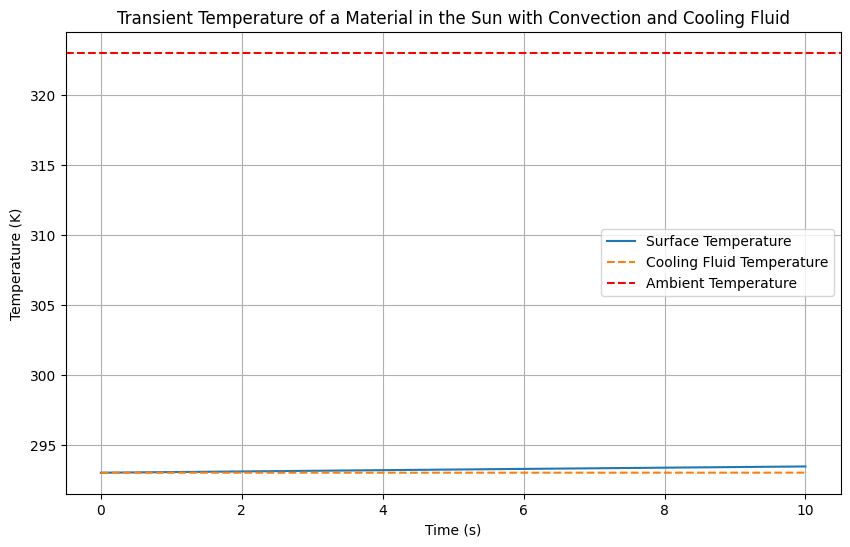

In [ ]:
x.plot()

In [ ]:
T_fluid_0 = 293
T_amb = 323
T_0 = 293
panel_length = 1 # (m)
panel_width = .05 # (m)
timesteps = 200
x_steps = 50
y_steps = 1
x_length = panel_length / x_steps
y_length = panel_width / y_steps
panel_length_array = np.linspace(0, panel_length, x_steps)
T_fluid_matrix = np.zeros((timesteps, x_steps, y_steps))  #time, long, short dir
T_panel_matrix = np.zeros((timesteps, x_steps, y_steps))
T_fluid_matrix[0][:] = T_fluid_0 * np.ones(y_steps)
T_panel_matrix[0][:] = T_0 * np.ones(y_steps)
time_dur = 0
mass_flow_rate = .001 # kg/s
all_temps = []
for i in range(timesteps - 1):  # for each timestep
  for j in range(x_steps):  # for each point in the long direction
    panel_point_ij = panel_block(T_panel_matrix[i][j][:], T_amb, T_fluid_matrix[i][j][:], (x_length, y_length), mass_flow_rate)
    T_panel_matrix[i+1][j][:] = panel_point_ij.temperatures[-1]
    if j < x_steps - 1:
      T_fluid_matrix[i+1][j+1][:] = panel_point_ij.fluid_temperatures[-1]
    if time_dur == 0:
      time_dur = panel_point_ij.time_duration
      fluid_mass = panel_point_ij.fluid_mass
      area = panel_point_ij.A
      specific_heat = panel_point_ij.fluid_specific_heat
  all_temps.append(T_fluid_matrix[i][:])
  T_fluid_matrix[i+1][0][:] = T_fluid_0 * np.ones(y_steps)



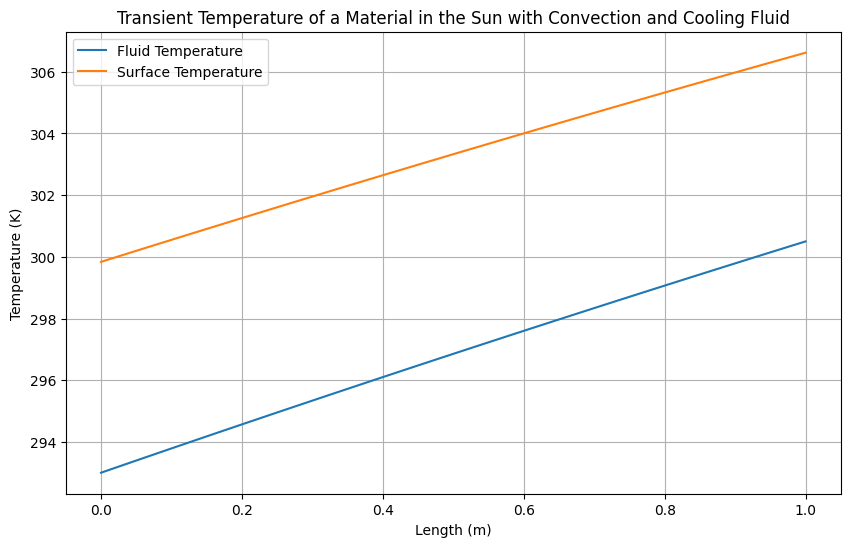

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(panel_length_array, T_fluid_matrix[-1][:], label="Fluid Temperature")
plt.plot(panel_length_array, T_panel_matrix[-1][:], label="Surface Temperature")
plt.title("Transient Temperature of a Material in the Sun with Convection and Cooling Fluid")
plt.xlabel("Length (m)")
plt.ylabel("Temperature (K)")
plt.legend()
plt.grid()
plt.show()

294.7513566402194


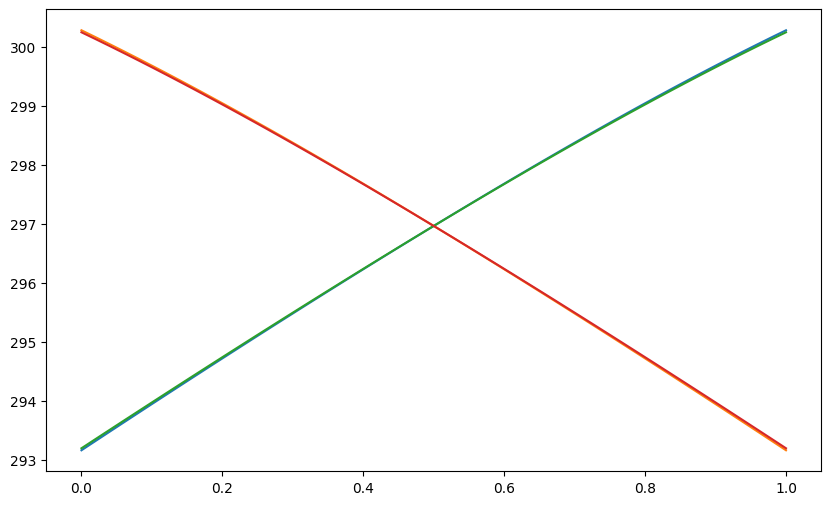

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(panel_length_array, T1, label="Fluid Temperature")
plt.plot(panel_length_array, T2, label="Surface Temperature")
plt.plot(panel_length_array, T1new, label="Fluid Temperature")
plt.plot(panel_length_array, T2new, label="Surface Temperature")

## ARCHIVE

## No radiation panel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class panel:
  def __init__(self, T_amb, T_fluid_i, panel_dimensions, fluid_depth, steps, air_speed, fluid_specific_heat, fluid_density, k, h_amb, h_fluid):
    self.steps = steps
    self.T_fluid = np.ones(steps + 1) # T profile of fluid
    self.T_panel_fluid = np.ones(steps) # T profile of fluid side of panel
    self.T_panel_amb = np.ones(steps) # T profile of ambient side of panel
    self.T_fluid[0] = T_fluid_i
    self.panel_length, self.panel_width, self.panel_thickness = panel_dimensions
    self.length_scale = self.panel_length * np.linspace(0, 1, steps)
    self.area = self.panel_width * self.panel_length / steps
    self.mass_rate = air_speed * fluid_depth * self.panel_width * fluid_density
    for i in range(0, self.T_fluid.size - 1):
      q_dot = (T_amb - self.T_fluid[i]) / (1 / h_fluid + self.panel_thickness / k + 1 / h_amb) # J / m2 * s
      total_q_dot = q_dot * self.area
      self.T_panel_amb[i] = - q_dot / h_amb + T_amb
      self.T_panel_fluid[i] = q_dot / h_fluid + self.T_fluid[i]
      delta_t_fluid = total_q_dot / self.mass_rate / fluid_specific_heat
      self.T_fluid[i+1] = self.T_fluid[i] + delta_t_fluid

  def show_graphs(self):
    plt.xlabel("Distance (m)")
    plt.ylabel("Temperature (C)")
    plt.title("Panel Cooling")
    plt.plot(self.length_scale, self.T_fluid[:self.steps], label='Fluid')
    plt.plot(self.length_scale, self.T_panel_fluid, label='Panel Fluid Side')
    plt.plot(self.length_scale, self.T_panel_amb, label='Panel Ambient Side')
    plt.legend()

## Air Cooling

In [ ]:
# T_amb, T_fluid_i, panel_dimensions, fluid_depth, steps, air_speed, fluid_specific_heat, fluid_density, k, h_amb, h_fluid

air_cooling = panel(45, 20, (1, .5, .03), .05, 10000, 1, 1, 1225, 1000, 20, 20)

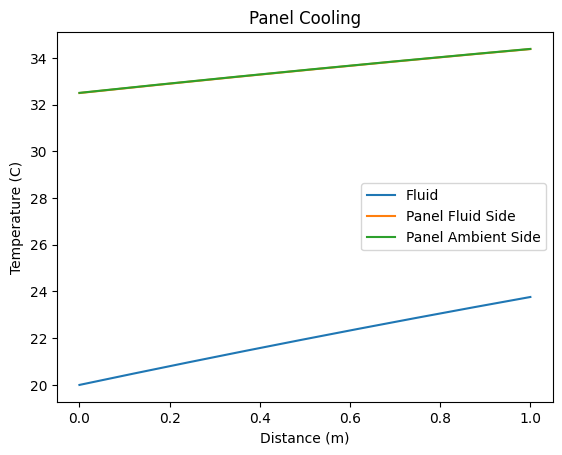

In [ ]:
air_cooling.show_graphs()

## Water Cooling

In [ ]:
# T_amb, T_fluid_i, panel_dimensions, fluid_depth, steps, air_speed, fluid_specific_heat, fluid_density, k, h_amb, h_fluid
water_cooling = panel(45, 20, (1, .05, .02), .05, 10000, .05, 4.184, 1000, 1000, 20, 500)

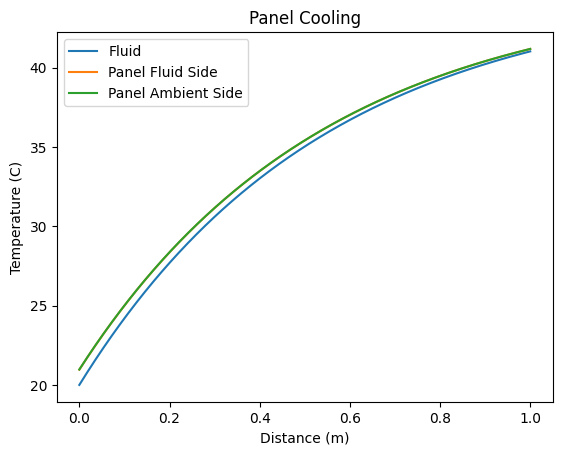

In [ ]:
water_cooling.show_graphs()

In [ ]:
water_cooling.mass_rate

0.12500000000000003

In [ ]:


steps = 10000

# Initialization
Tf = np.ones(steps + 1) # T profile of fluid
Ts_f = np.ones(steps) # T profile of fluid side of panel
Ts_b = np.ones(steps) # T profile of ambient side of panel
T_amb = 45  # amb temp in C
Tfi = 20  # initial fluid temp in C
Tf[0] = Tfi


# Panel Properties
width = .05  # m
length = 1  # m
panel_thickness = .03  # m
k = 1000 # J / m * C * s

# Cross-sectional Area
area = width * length / steps

# Fluid Properties
air_speed = 5  # m / s
specific_heat_fluid = 1  # J / g * C
thickness_fluid = 0.05  # m
density_fluid = 1225 # air density g / m3
mass_rate = air_speed * thickness_fluid * width * density_fluid # g / s
h_fluid = 20 # J / m2 * C * s
h_amb = 20 # J / m2 * C * s


for i in range(0, Tf.size - 1):
  q_dot = (T_amb - Tf[i]) / (1 / h_fluid + panel_thickness / k + 1 / h_amb) # J / m2 * s
  total_q_dot = q_dot * area
  Ts_b[i] = - q_dot / h_amb + T_amb
  Ts_f[i] = q_dot / h_fluid + Tf[i]
  delta_t_fluid = total_q_dot / mass_rate / specific_heat_fluid
  Tf[i+1] = Tf[i] + delta_t_fluid

In [ ]:
import numpy as np

steps = 10000

# Initialization
Tf = np.ones(steps + 1) # T profile of fluid
Ts_f = np.ones(steps) # T profile of fluid side of panel
Ts_b = np.ones(steps) # T profile of ambient side of panel
T_amb = 45  # amb temp in C
Tfi = 20  # initial fluid temp in C
Tf[0] = Tfi


# Panel Properties
width = .05  # m
length = 1  # m
panel_thickness = .03  # m
k = 1000 # J / m * C * s

# Cross-sectional Area
area = width * length / steps

# Fluid Properties for water
water_speed = 5  # m / s
specific_heat_fluid = 4.184  # J / g * C
thickness_fluid = 0.05  # m
density_fluid = 1000 # air density g / m3
mass_rate = air_speed * thickness_fluid * width * density_fluid # g / s
h_fluid = 500 # J / m2 * C * s
h_amb = 20 # J / m2 * C * s


for i in range(0, Tf.size - 1):
  q_dot = (T_amb - Tf[i]) / (1 / h_fluid + panel_thickness / k + 1 / h_amb) # J / m2 * s
  total_q_dot = q_dot * area
  Ts_b[i] = - q_dot / h_amb + T_amb
  Ts_f[i] = q_dot / h_fluid + Tf[i]
  delta_t_fluid = total_q_dot / mass_rate / specific_heat_fluid
  Tf[i+1] = Tf[i] + delta_t_fluid

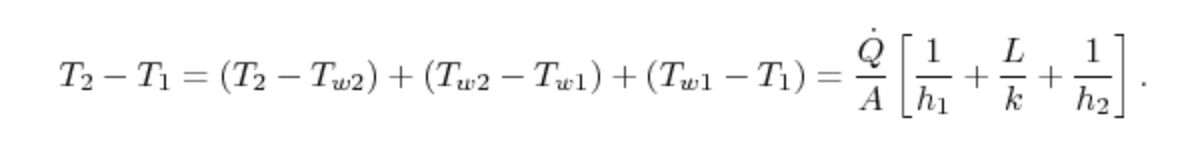